# Differentiation techniques:
Here I want to compare the different differention technqiues given by my own implementation and in pysindy.

In [1]:
from spectral_derivative import flattenandextendfunc_1d,calc_deriv_fftn,calc_deriv_fftn_with_ext
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
from test_data import add_noise

## Data

In [3]:
# Do the same for one dimensional function
n= 100# amount of points
L=3#2*np.pi#length of domain
dx = L/n
const=0#np.pi/2
a=1
b=1
x = np.linspace(-L/2+const, L/2+const, num=n)
#f = np.cos(a*x+b)
#dfdx = -a*np.sin(a*x+b)
f=np.exp(a*x+b)
dfdx=a*f

## Derivatives

In [4]:
from pysindy.differentiation import SmoothedFiniteDifference, SpectralDerivative

In [5]:
dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f, dx)
dfdx_myfft =  calc_deriv_fftn_with_ext(f,[x],[0],[dx])
dfdx_fft =  SpectralDerivative()._differentiate(f, dx)
dfdx_sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})._differentiate(f, dx)

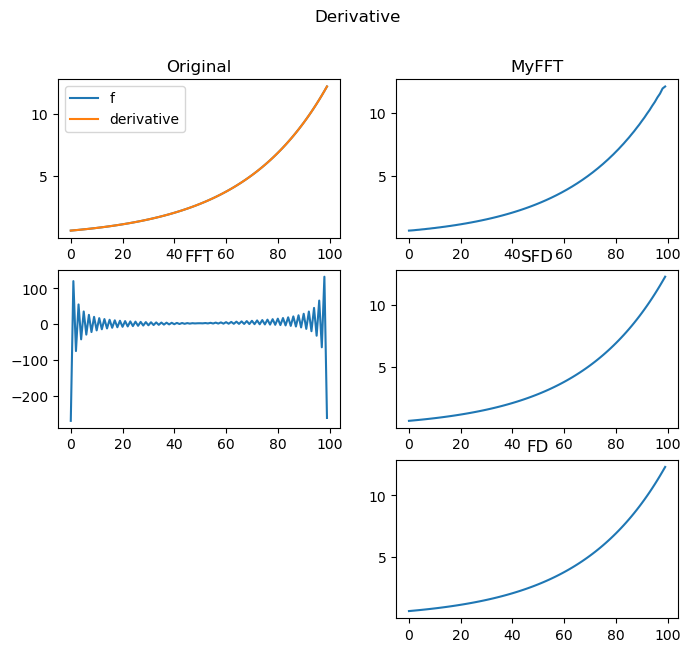

In [6]:
plt.figure(figsize=(8,7))
plt.suptitle("Derivative")
plt.subplot(3,2,1)
plt.title("Original")
plt.plot(f,label="f")
plt.plot(dfdx,label="derivative")
plt.legend()
plt.subplot(3,2,2)
plt.title("MyFFT")
plt.plot(dfdx_myfft,label="MyFFT")
plt.subplot(3,2,3)
plt.title("FFT")
plt.plot(dfdx_fft,label="FFT")
plt.subplot(3,2,4)
plt.title("SFD")
plt.plot(dfdx_sfd,label="SFD")
plt.subplot(3,2,6)
plt.title("FD")
plt.plot(dfdx_fd)

In [7]:
x.size

100

In [8]:
newf,newx,n= flattenandextendfunc_1d(f,x)
df =  SpectralDerivative()._differentiate(newf, dx)
start = [n]
end = [sum(o) for o in zip([n], list(f.shape))] #end = n0+u.shape[0],n1+u.shape[1],...
myslice =tuple(slice(*indexes) for indexes in zip(start, end))
dfdx_fft_ext = df[myslice]

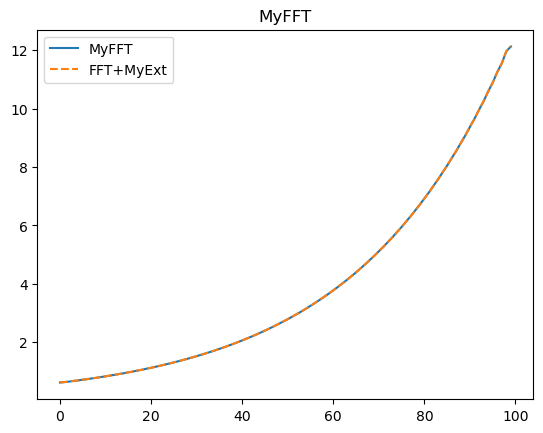

In [9]:
plt.title("MyFFT")
plt.plot(dfdx_myfft,label="MyFFT")
plt.plot(dfdx_fft_ext,'--',label="FFT+MyExt")
plt.legend()

## Derivatives with noise

Noise level: 0
Noise level: 1e-10
Noise level: 1e-09
Noise level: 1e-08
Noise level: 1e-07
Noise level: 1e-06
Noise level: 1e-05
Noise level: 0.0001
Noise level: 0.001


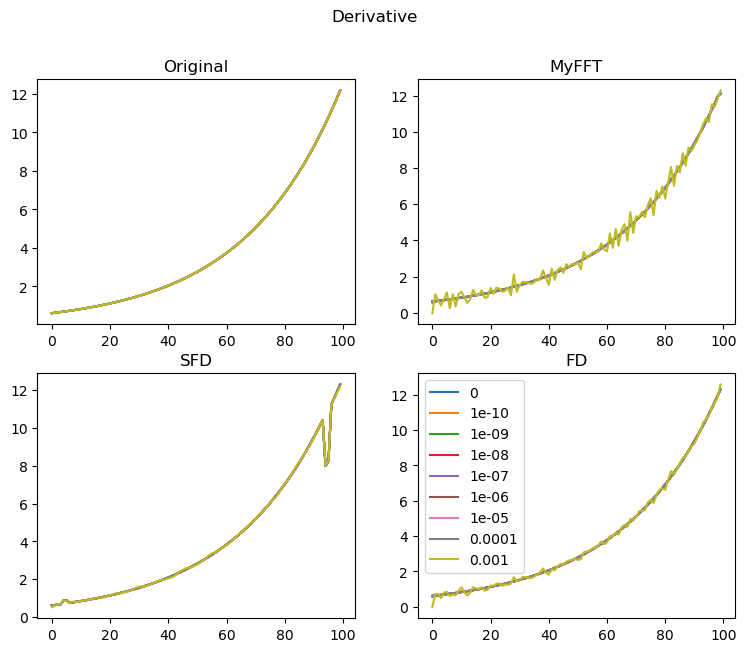

In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,8)]
plt.figure(figsize=(9,7))
plt.suptitle("Derivative")
plt.subplot(2,2,1)

#plt.plot(f,label="f")
#plt.plot(dfdx,label="derivative")
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    f_noise = add_noise(f,target_noise)
    dfdx_fd = ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(f_noise, dx)
    dfdx_myfft =  calc_deriv_fftn_with_ext(f_noise,[x],[0],[dx])
    dfdx_fft =  SpectralDerivative()._differentiate(f_noise, dx)
    dfdx_sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 10})._differentiate(f_noise, dx)
    plt.title("Original")
    plt.subplot(2,2,1)
    plt.plot(f_noise,label=str(target_noise))
    plt.subplot(2,2,2)
    plt.title("MyFFT")
    plt.plot(dfdx_myfft,label=str(target_noise))
    plt.subplot(2,2,3)
    plt.title("SFD")
    plt.plot(dfdx_sfd,label=str(target_noise))
    plt.subplot(2,2,4)
    plt.title("FD")
    plt.plot(dfdx_fd,label=str(target_noise))
plt.legend()

#plt.savefig("noise_levels")

### Fourier Derivative

In [16]:
# Do the same for one dimensional function
n= 100# amount of points
L=3#2*np.pi#length of domain
dx = L/n
const=0#np.pi/2
a=9
b=1
x = np.linspace(-L/2+const, L/2+const, num=n)
#f = np.cos(a*x+b)
#dfdx = -a*np.sin(a*x+b)
f=np.exp(a*x+b)
dfdx=a*f
dfdx_myfft =  calc_deriv_fftn_with_ext(f,[x],[0],[dx])

In [17]:
def flatten(x,A,B,n_ext=None):
    n = int(x.size/2) if n_ext is None else n_ext
    dx=x[1]-x[0]
    newx=np.arange(A-n*dx,B +n*dx,dx)
    f=np.empty(newx.size, dtype=float)
    a=29
    half = A+(B-A)/2
    dx = x[1]-x[0]
    f[newx<=half]=1.0/(1.0 + np.exp(-a*(newx[newx<=half]-(A-n/2*dx))))
    f[newx>half]=-1.0/(1.0 + np.exp(-a*(newx[newx>half]-(B+n/2*dx))))+1.0
    f[n:x.size+n]=1#values from [x0 to xn] must be 1
    f[f>0.99999]=1 #numeric values must be 1
    f[f<1e-7]=0
    #f[f>0.999999]=1
    return newx,n,f
    
def flattenandextendfunc_1d(f,x,n_ext=None):
    # error handling
    if f.size!=x.size:
        print("Error: f and x do not have same size: f.size="
              +str(f.size)+",x.size="+str(x.size))
        print("Exit flattenandextendfu")
        return None
    # Get necessary data to extend f
    A=x[0]
    B=x[x.size-1]
    # Create newf: in the middle equal to f, continuous extension such that 
    # start and endpoint are equal to one
    newx,n,newf=flatten(x,A,B,n_ext)
    print(f"Extending function with 2*{n} data points")
    # Create new data
    oldf=newf.copy()
    # Get slope at beg and end
    slope_start = (f[1]-f[0])/dx
    slope_end = (f[f.size-1]-f[f.size-2])/dx
    # Extend oldf
    oldf[n:n+f.size]=f
    oldf[n+f.size:]=slope_end*dx*np.arange(1, oldf[n+f.size:].size+1)+f[f.size-1]
    oldf[:n]=f[0]-slope_start*dx*np.arange(1, oldf[:n].size+1)[::-1] #[::-1] means reverse array
    newf = newf*oldf
    return newf,newx,n

In [18]:
newx,n,phi=flatten(x,x[0],x[-1])

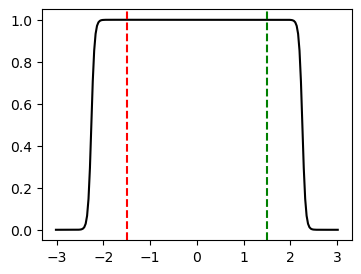

In [19]:
plt.figure(figsize=(4,3))
plt.plot(newx,phi,color="black")
plt.axvline(x=x[0], color='red', linestyle='--')
plt.axvline(x=x[-1], color='green', linestyle='--')
plt.show()

Extending function with 2*50 data points


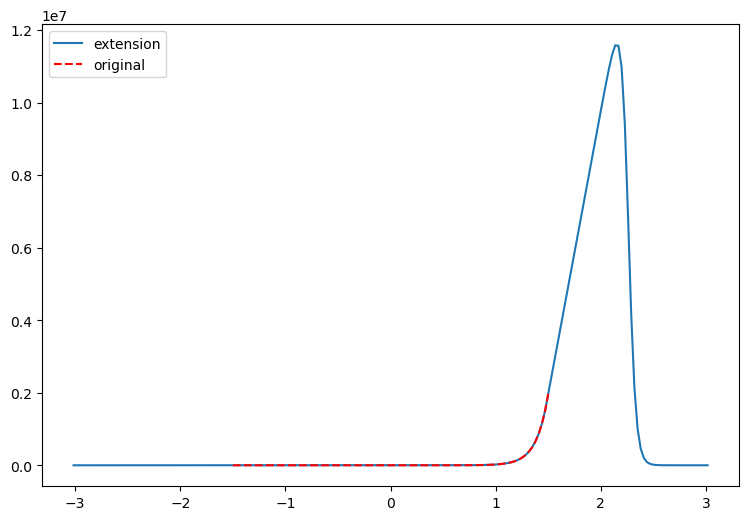

In [20]:
newf,newx,newn= flattenandextendfunc_1d(f,x)
plt.figure(figsize=(9,6))
plt.plot(newx,newf, label='extension')
plt.plot(x,f,'--',color='red',label='original')
plt.legend(loc=2)
plt.show()

In [21]:
dfdx_FFT = calc_deriv_fftn(f,[0], [dx])
newdfdx_FFT = calc_deriv_fftn(newf,[0], [dx])
start = [newn]
end = [sum(o) for o in zip(start, list(f.shape))] #end = n0+u.shape[0],n1+u.shape[1],...
myslice =tuple(slice(*indexes) for indexes in zip(start, end))
dfdx_myfft = newdfdx_FFT[myslice]

In [22]:
dfdx_fdext= ps.FiniteDifference(order=2, d=1, axis=0, drop_endpoints=False)._differentiate(newf, dx)

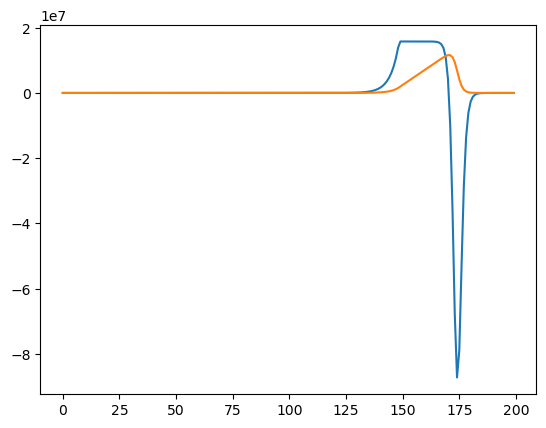

In [23]:
plt.plot(dfdx_fdext)
plt.plot(newf)

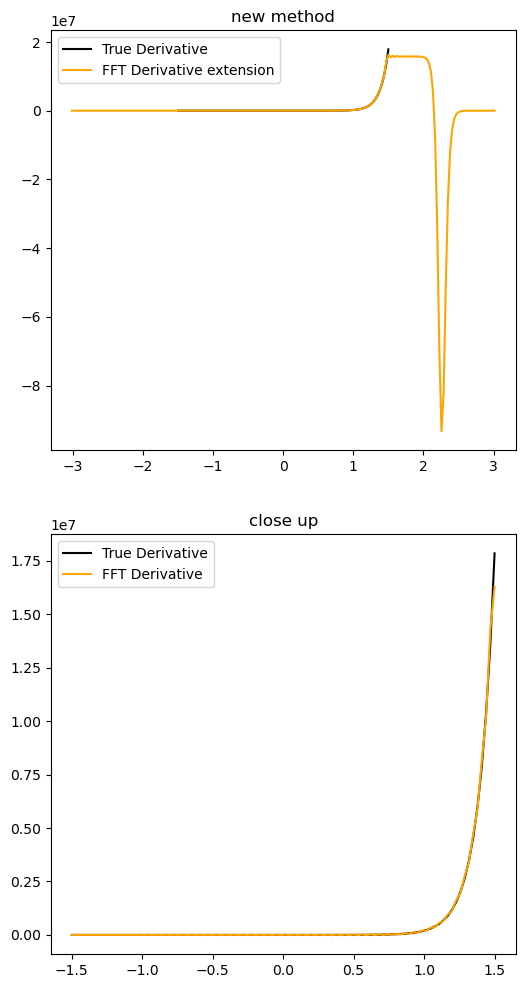

In [24]:
#Check if calculating the derivative holds
dfdx_FFT = calc_deriv_fftn(f,[0], [dx])
newdfdx_FFT = calc_deriv_fftn(newf,[0], [dx])

# Plot Derivatives
plt.figure(figsize=(6,12))
plt.subplot(2,1,1)
plt.title("new method")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(newx,newdfdx_FFT,color='orange', label = 'FFT Derivative extension')
plt.legend(loc=0)

plt.subplot(2,1,2)
plt.title("close up")
plt.plot(x,dfdx, color='k', label ='True Derivative')
plt.plot(x,dfdx_myfft,color='orange', label = 'FFT Derivative')
plt.legend(loc=0)

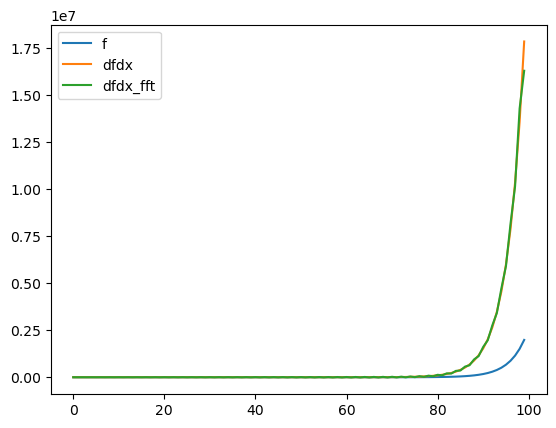

In [25]:
plt.plot(f,label='f')
plt.plot(dfdx,label='dfdx')
plt.plot(dfdx_myfft,label='dfdx_fft')
plt.legend()

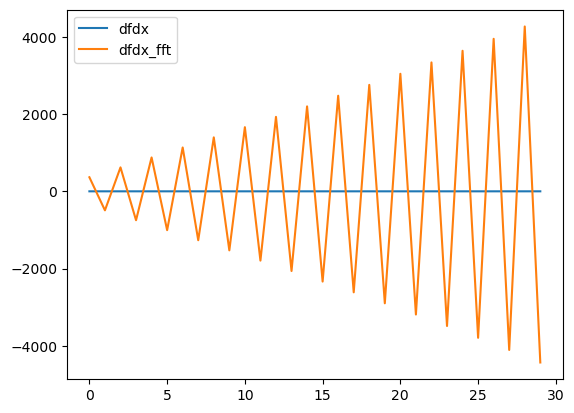

In [26]:
n_start=0
n_end=30
plt.plot(dfdx[n_start:n_end],label='dfdx')
plt.plot(dfdx_myfft[n_start:n_end],label='dfdx_fft')
plt.legend()